In [1]:
!pip install pytorch-lightning==0.7.6

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install torchvision

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [69]:
import os
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torchvision import models
import matplotlib.pyplot as plt

In [70]:
# 前処理
transform = transforms.Compose([
        transforms.Resize((256,256)),#画像の大きさを変更
        #transforms.CenterCrop(224),
        transforms.ToTensor(),#Tensor型に変換
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#色情報の標準化
])

In [71]:
datafolder = "Linkdata/datasetkato/MLdataset"
dataset = datasets.ImageFolder(datafolder, transform) #前処理の実行
print(dataset[0][0].shape)
#display(dataset[0])
print(len(dataset))
# 学習 : 検証 : テスト = 70% : 20% : 10%
n_train = int(len(dataset) * 0.7)
n_val = int(len(dataset) * 0.2)
n_test = len(dataset) - n_train - n_val

# ランダムに分割を行うため、シードを固定して再現性を確保
torch.manual_seed(0)
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
print(len(train))
print(len(test))

torch.Size([3, 256, 256])
34418
24092
3443


In [72]:
global opt,fag,loss
train_loss={}
train_acc={}
val_loss={}
val_acc={}

class TrainNet(pl.LightningModule):
    @pl.data_loader
    def train_dataloader(self):
        #データセットを使ってバッチサイズ分のデータを生成する。またデータのシャッフル機能も持つ。
        return torch.utils.data.DataLoader(train, self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

    #学習データに対する処理
    def training_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
#        if self.current_epoch%5==0:
              # 学習途中の状態を保存する。
#                 torch.save(
#                     {
#                         "epoch": self.current_epoch,
#                         "model_state_dict": net.state_dict(),
#                         "optimizer_state_dict": opt.state_dict(),
#                       "losslogger": loss,
#                     },
#                   "Linkdata/datasetkato/model.tar_{}".format(self.current_epoch+1),

#                 )
                
        # グラフ用
        tensorboard_logs = {'train/train_loss': loss, 'train/train_acc': acc} # tensorboard
        results = {'loss': loss, 'log': tensorboard_logs}
        train_loss[self.current_epoch]=loss.item()
        train_acc[self.current_epoch]=acc.item()
        
        return results

class ValidationNet(pl.LightningModule):
    @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(val, self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def validation_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'val_loss': loss, 'val_acc': acc}
        
        return results

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        
        # 学習途中の状態を保存する。
        if self.current_epoch%5==0:
            
            torch.save(
                {
                    "epoch": self.current_epoch,
                    "model_state_dict": net.state_dict(),
                    "optimizer_state_dict": opt.state_dict(),
                  "losslogger": avg_loss,
                },
              "Linkdata/datasetkato/model.tar_{}".format(self.current_epoch+1),

            )
            
         # グラフ用       
        tensorboard_logs = {'val/avg_loss': avg_loss, 'val/avg_acc': avg_acc}
        results = {'val_loss': avg_loss, 'val_acc': avg_acc, 'log': tensorboard_logs}
        val_loss[self.current_epoch]=avg_loss.item()
        val_acc[self.current_epoch]=avg_acc.item()
        return results

class TestNet(pl.LightningModule):
    @pl.data_loader
    def test_dataloader(self):
        return torch.utils.data.DataLoader(test, self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def test_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'test_loss': loss, 'test_acc': acc}
        return results

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        results = {'test_loss': avg_loss, 'test_acc': avg_acc}
        return results

class Net(TrainNet, ValidationNet, TestNet):

    def __init__(self, batch_size=2, num_workers=os.cpu_count(), pin_memory=True):
        super(Net, self).__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers

        # 使用する層の宣言
        # 学習済みモデルを利用
        self.conv = models.mobilenet_v3_large(pretrained=True)
        
        # 学習済みのパラメータを固定
        for param in self.conv.parameters():
            # 学習済みのパラメータを固定
            #print(param)
            param.requires_grad = False
            # 学習済みのパラメータを固定しない
            #param.requires_grad = True
            
        #転移学習用のモデルに変更
        self.conv.classifier= torch.nn.Sequential(
          torch.nn.Linear(in_features=960, out_features=1280, bias=True),
          torch.nn.Hardswish(),
          torch.nn.Dropout(p=0.2, inplace=True),
          torch.nn.Linear(in_features=1280, out_features=30, bias=True))
        
        #デフォルトでTrueなので以下4行は実は不要
        self.conv.classifier[0].weight.requires_grad = True
        self.conv.classifier[3].weight.requires_grad = True
        self.conv.classifier[0].bias.requires_grad = True
        self.conv.classifier[3].bias.requires_grad = True
        
    #目的関数の設定
    def lossfun(self, y, t):
        return F.cross_entropy(y, t)
    #optimizerの設定
    def configure_optimizers(self):
        global opt
        opt=torch.optim.RMSprop(self.parameters(), lr=5e-3, weight_decay=5e-3)
        return opt
    #順伝播
    def forward(self, x):
        x = self.conv(x)
        return x
    
# 乱数のシードを固定
torch.manual_seed(0)

# 使用していない GPU のメモリを解放
#torch.cuda.empty_cache()

In [73]:
# ネットワークの学習準備
net = Net()
print(net)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#  重みの読み込み 学習を途中から再開する場合
# opt=torch.optim.Adam(net.parameters(), lr=5e-3, weight_decay=5e-3)
# checkpoint=torch.load("/content/drive/MyDrive/temp11/8/model8.tar_72",map_location=device)
# net.load_state_dict(checkpoint["model_state_dict"])
# opt.load_state_dict(checkpoint["optimizer_state_dict"])
# #net.put_epoch(checkpoint["epoch"])
# epoch=checkpoint['epoch']
# loss=checkpoint['losslogger']

Net(
  (conv): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
        

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
# 単一のGPUで学習を行う場合
trainer = Trainer(max_epochs=75,gpus=1)
# trainer = Trainer(max_epochs=61)
# ネットワークの学習
trainer.fit(net)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                                      | Type                 | Params
-------------------------------------------------------------------------------
0   | conv                                      | MobileNetV3          | 4 M   
1   | conv.features                             | Sequential           | 2 M   
2   | conv.features.0                           | Conv2dNormActivation | 464   
3   | conv.features.0.0                         | Conv2d               | 432   
4   | conv.features.0.1                         | BatchNorm2d          | 32    
5   | conv.features.0.2                         | Hardswish            | 0     
6   | conv.features.1                           | InvertedResidual     | 464   
7   | conv.features.1.block                     | Sequential           | 464   
8   | conv.features.1.block.0                   | Conv2dNormActivation | 176   
9   

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [75]:
# 最終的なエポックの検証データに対する結果
trainer.callback_metrics

{'loss': tensor(11.8936, device='cuda:0'),
 'train/train_loss': tensor(11.8936, device='cuda:0'),
 'train/train_acc': tensor(0., device='cuda:0'),
 'val_loss': tensor(0.7490, device='cuda:0'),
 'val_acc': tensor(0.9557, device='cuda:0'),
 'val/avg_loss': tensor(0.7490, device='cuda:0'),
 'val/avg_acc': tensor(0.9557, device='cuda:0'),
 'epoch': 74}

In [76]:
# 学習済みモデルの保存
torch.save(net.state_dict(), 'Linkdata/datasetkato/mobilenetv3_nosolid3.pt')

In [77]:
# 学習済みモデルの保存
torch.save(net.to('cpu').state_dict(), 'Linkdata/datasetkato/mobilenetv3_CPU_nosolid3.pt')

In [78]:
# ネットワークの準備
net = Net().to('cpu')

# 重みの読み込み
net.load_state_dict(torch.load('Linkdata/datasetkato/mobilenetv3_CPU_nosolid3.pt'))
net.eval()

# 予測値の計算
y = net.forward(test[0][0].unsqueeze(0))

# 教師データ
print(test[0][1])

# 予測ラベル
print(y.argmax())

#確率
y_proba = F.softmax(y,dim=1)
print(y_proba)
y_proba = y_proba.detach().clone().numpy().max()
print(y_proba)
y_proba = '{:.1%}'.format(y_proba)
print(y_proba)

17
tensor(17)
tensor([[0.0000e+00, 0.0000e+00, 3.5579e-42, 3.5713e-39, 1.3200e-41, 0.0000e+00,
         0.0000e+00, 6.2132e-39, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         7.9306e-26, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 8.9894e-29, 6.0329e-39, 0.0000e+00, 2.5044e-35, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5400e-42, 0.0000e+00, 7.0065e-45]],
       grad_fn=<SoftmaxBackward0>)
1.0
100.0%


In [79]:
a=net.forward(test[10][0].unsqueeze(0))
print(a.argmax())

tensor(27)


In [80]:
print(test[10][1])

27


In [81]:
predict=[]
answer=[]
num=len(test)
#print(num)
for i in range(num):
    pre = net.forward(test[i][0].unsqueeze(0))
    #print(pre)
    # 予測値の計算
    predict.append(pre.argmax().detach().clone().numpy().item())
    
    # 答えラベル
    ans=test[i][1]
    answer.append(ans)
print(predict)

[17, 10, 4, 0, 24, 11, 6, 15, 14, 8, 27, 8, 3, 23, 1, 28, 3, 25, 10, 12, 9, 7, 23, 19, 27, 1, 25, 23, 8, 3, 12, 3, 25, 16, 3, 28, 2, 9, 23, 16, 25, 13, 21, 27, 16, 25, 26, 2, 25, 22, 13, 14, 20, 7, 2, 20, 3, 23, 25, 3, 27, 13, 9, 4, 21, 12, 20, 19, 14, 17, 0, 7, 28, 23, 24, 25, 26, 6, 2, 19, 19, 16, 15, 20, 3, 2, 15, 26, 24, 28, 25, 1, 24, 4, 2, 21, 12, 9, 2, 0, 1, 17, 6, 2, 6, 3, 25, 1, 17, 8, 15, 13, 24, 2, 13, 16, 27, 22, 14, 19, 4, 9, 0, 27, 4, 23, 12, 6, 23, 19, 15, 10, 13, 28, 16, 12, 11, 2, 16, 9, 19, 28, 17, 25, 27, 28, 1, 2, 8, 3, 25, 4, 28, 21, 28, 22, 16, 4, 23, 9, 6, 11, 16, 16, 4, 26, 19, 7, 2, 29, 12, 2, 6, 19, 16, 16, 7, 16, 28, 4, 25, 23, 21, 1, 20, 28, 2, 3, 7, 6, 26, 2, 25, 22, 13, 1, 17, 25, 24, 19, 19, 7, 27, 4, 19, 9, 7, 9, 25, 15, 17, 19, 28, 3, 23, 26, 14, 19, 1, 26, 10, 1, 14, 1, 2, 15, 2, 16, 14, 26, 8, 3, 0, 28, 13, 3, 1, 12, 24, 14, 28, 24, 15, 4, 10, 16, 4, 2, 3, 1, 0, 23, 24, 11, 3, 22, 11, 1, 16, 16, 24, 7, 0, 0, 7, 29, 2, 14, 27, 11, 14, 16, 14, 28, 16, 1

In [82]:
print(answer)

[17, 10, 5, 0, 24, 11, 6, 15, 14, 8, 27, 8, 3, 23, 1, 28, 3, 25, 10, 16, 9, 7, 29, 19, 27, 1, 25, 23, 8, 3, 12, 3, 25, 16, 3, 28, 2, 9, 23, 16, 25, 13, 21, 27, 16, 25, 26, 2, 25, 22, 13, 14, 20, 7, 2, 20, 3, 23, 25, 3, 27, 13, 9, 5, 21, 12, 20, 19, 14, 17, 0, 7, 28, 23, 24, 25, 26, 6, 2, 18, 19, 16, 15, 20, 3, 2, 15, 26, 24, 28, 25, 1, 24, 4, 2, 21, 12, 9, 2, 0, 1, 17, 6, 2, 6, 3, 25, 1, 17, 8, 15, 13, 24, 2, 13, 16, 27, 22, 14, 19, 5, 9, 0, 27, 5, 23, 12, 6, 23, 18, 15, 10, 13, 28, 16, 12, 11, 2, 16, 9, 19, 28, 17, 25, 27, 28, 1, 2, 8, 3, 25, 5, 28, 21, 28, 22, 16, 4, 23, 9, 6, 11, 16, 16, 4, 26, 16, 7, 2, 29, 12, 2, 6, 19, 16, 16, 7, 16, 28, 5, 25, 23, 21, 1, 20, 28, 2, 3, 7, 5, 26, 2, 25, 22, 13, 1, 17, 25, 24, 18, 19, 7, 27, 4, 19, 9, 7, 9, 25, 15, 17, 19, 28, 3, 23, 26, 14, 18, 1, 26, 10, 1, 14, 1, 2, 22, 2, 16, 14, 26, 8, 3, 0, 28, 13, 3, 1, 16, 24, 14, 28, 24, 15, 4, 10, 16, 5, 2, 3, 1, 0, 29, 24, 11, 3, 22, 11, 1, 16, 16, 24, 7, 0, 0, 7, 29, 2, 14, 27, 29, 14, 16, 14, 28, 16, 1

In [83]:
!pip install sklearn
from sklearn.metrics import classification_report
#精度　f1_score
print(classification_report(answer, predict))

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       0.97      1.00      0.99       117
           2       1.00      1.00      1.00       210
           3       1.00      1.00      1.00       146
           4       0.71      1.00      0.83        75
           5       0.00      0.00      0.00        41
           6       0.93      0.92      0.93       171
           7       1.00      1.00      1.00       126
           8       1.00      0.96      0.98        95
           9       1.00      1.00      1.00        93
          10       1.00      1.00      1.00        93
          11       0.87      1.00      0.93        88
          12       0.89      1.00      0.94        96
          13       1.00      1.00      1.00        99
          14       1.00      1.00      1.00       132
          15       0.93      1.00      0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
#テストデータの精度
trainer.test(net)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': tensor(0.9530, device='cuda:0'),
 'test_loss': tensor(0.9411, device='cuda:0')}
--------------------------------------------------------------------------------


In [91]:
print(train_loss)

{0: 0.0, 1: 0.0032092828769236803, 2: 1.8179085600422695e-05, 3: 0.04098180681467056, 4: 0.0, 5: 0.0534810833632946, 6: 7.329023838043213, 7: 0.20510604977607727, 8: 0.4751015305519104, 9: 0.0, 10: 11.973531723022461, 11: 11.843006134033203, 12: 4.555225849151611, 13: 34.157814025878906, 14: 13.381324768066406, 15: 6.277155876159668, 16: 0.2975993752479553, 17: 0.022388378158211708, 18: 13.40904426574707, 19: 1.710624019324314e-05, 20: 26.379249572753906, 21: 0.003765139728784561, 22: 2.0832064151763916, 23: 34.72874069213867, 24: 7.253326892852783, 25: 0.0, 26: 5.502551078796387, 27: 0.9951400756835938, 28: 6.586010932922363, 29: 0.3345695436000824, 30: 0.07575485110282898, 31: 0.0724492222070694, 32: 8.40418397274334e-06, 33: 1.209517002105713, 34: 2.3245770535140764e-06, 35: 0.0, 36: 20.478879928588867, 37: 2.6369431018829346, 38: 6.951870918273926, 39: 0.0, 40: 1.812919020652771, 41: 16.486560821533203, 42: 0.0, 43: 0.02208467572927475, 44: 28.016603469848633, 45: 0.0, 46: 0.0, 47:

In [92]:
print(val_loss)

{0: 1.830745816230774, 1: 0.6752424240112305, 2: 0.9906416535377502, 3: 0.531221330165863, 4: 1.2779045104980469, 5: 0.47531819343566895, 6: 0.46047598123550415, 7: 0.6821287274360657, 8: 0.4592181444168091, 9: 0.8305686712265015, 10: 1.1862308979034424, 11: 0.9768761992454529, 12: 0.5404120087623596, 13: 0.6518759727478027, 14: 0.3251732587814331, 15: 1.8403651714324951, 16: 0.24953947961330414, 17: 0.46228352189064026, 18: 4.1363959312438965, 19: 1.2957520484924316, 20: 2.9837348461151123, 21: 0.3580312132835388, 22: 0.9507881999015808, 23: 1.0731797218322754, 24: 0.8447695374488831, 25: 1.3264243602752686, 26: 0.4551795423030853, 27: 1.0456798076629639, 28: 1.2706754207611084, 29: 1.596423625946045, 30: 0.6241576075553894, 31: 1.3256816864013672, 32: 0.6310542821884155, 33: 0.26566383242607117, 34: 0.5929809808731079, 35: 1.2516130208969116, 36: 0.6714505553245544, 37: 0.5843513607978821, 38: 0.9632453918457031, 39: 0.6420164704322815, 40: 0.3782474100589752, 41: 0.7141537666320801,

In [94]:
print(train_acc)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 0.5, 7: 1.0, 8: 0.5, 9: 1.0, 10: 0.0, 11: 0.5, 12: 0.5, 13: 0.0, 14: 0.5, 15: 0.5, 16: 1.0, 17: 1.0, 18: 0.5, 19: 1.0, 20: 0.5, 21: 1.0, 22: 0.5, 23: 0.0, 24: 0.5, 25: 1.0, 26: 0.5, 27: 0.5, 28: 0.5, 29: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 0.5, 34: 1.0, 35: 1.0, 36: 0.0, 37: 0.5, 38: 0.5, 39: 1.0, 40: 0.5, 41: 0.5, 42: 1.0, 43: 1.0, 44: 0.0, 45: 1.0, 46: 1.0, 47: 0.5, 48: 1.0, 49: 0.5, 50: 1.0, 51: 0.5, 52: 1.0, 53: 0.5, 54: 1.0, 55: 0.5, 56: 1.0, 57: 1.0, 58: 0.5, 59: 1.0, 60: 0.5, 61: 1.0, 62: 0.5, 63: 0.5, 64: 0.5, 65: 1.0, 66: 1.0, 67: 1.0, 68: 0.5, 69: 0.5, 70: 1.0, 71: 1.0, 72: 1.0, 73: 0.0, 74: 0.0}


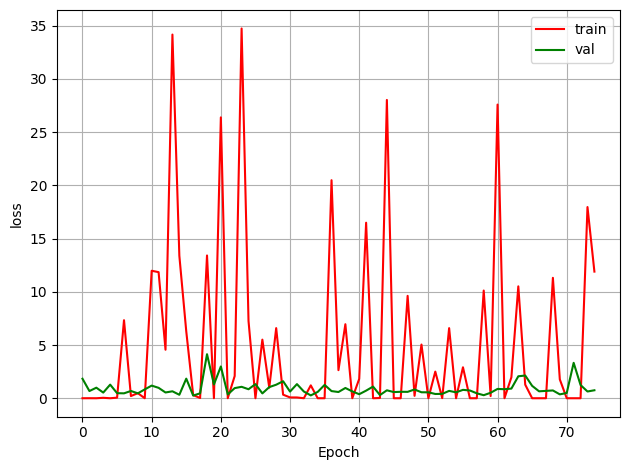

In [90]:
fig, ax = plt.subplots()
t = np.linspace(1,75,10)
ax.set_xlabel('Epoch')
ax.set_ylabel('loss')
ax.grid()
ax.plot(train_loss.keys(), train_loss.values(),color = 'red',label='train')
ax.plot(val_loss.keys(), val_loss.values(),color = 'green',label='val')
ax.legend(loc = 0)
fig.tight_layout()
plt.show()

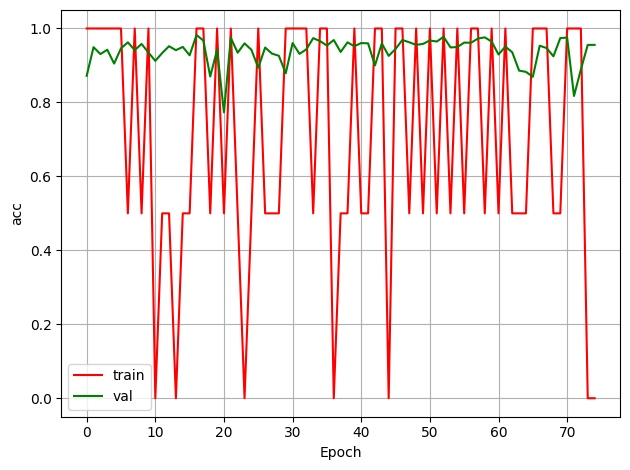

In [93]:
fig, ax = plt.subplots()
t = np.linspace(1,10,10)
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')
ax.grid()
ax.plot(train_acc.keys(), train_acc.values(),color = 'red',label='train')
ax.plot(val_acc.keys(), val_acc.values(),color = 'green',label='val')
ax.legend(loc = 0)
fig.tight_layout()
plt.show()

In [ ]:
!pip install tensorboard==1.14.0
!pip install tb-nightly

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=/content/lightning_logs

In [77]:
# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6006: logdir /content/lightning_logs (started 1:07:06 ago; pid 15422)


In [78]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
# notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir /content/lightning_logs (started 1:07:17 ago; port 6006, pid 15422).
